# Usage
This code using model at model/static/CNN/BS16/3500_3516/ver3_, using 3p4 GHz dataset  
* Training data was generated by DeepMIMOData/Static_BS16/freq_symb_1ant_612antsub_ver4  
  *      min  = -2.7632e-5
  *      max  = 2.7672e-5
  *      mean = 6.8901e-9  
* Map-based data for inference: CDL Customization/Data/ver3  
    was generated by ETS_CDLcustomize_v8_0_Loop_similar_v713.mlx  
  *      min  = -7.3395e-05
  *      max  = 7.1074e-5
  *      mean = -1.1906e-6

* The model is saved in model/static/CNN/BS16/3500_3516/ver4_

# Normalization method
* The models were trained with data instance min-max normalized, each training sample was scaled according to its min and max
** according training label are also normalized with min, max of its according training data sample (have not change the code)
* This version normalize each inference data sample with its own min and max
* The output of the CNN will be then de-normalized with the min and max of the input 
(actually this version is not really too different to the version this copied from)

In [1]:
import h5py
import torch
import torch.nn as nn
import random


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
from scipy.io import savemat
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('../helper')
from utils import CNN_Est
import loader
import utils


In [2]:
rowss = '3500_3516'
model_path = '../model/static/CNN/BS16/'+ rowss + '/ver4_/'
CDL_path = '../../CDL Customization/Data/ver3/'
SNR = np.arange(0, 31, 5) # 0:5:30 dB
device = 'cpu'
BATCH_SIZE = 32

average_nmse_LS_LI = []
average_nmse_LI_NN = []
average_nmse_LS_NN = []


for snr in SNR:
    # variables = torch.load(model_path + str(snr) + 'dB/CNN_1_variable.pth')

    # trainData_LS_min = variables['train_min_LS']
    # trainData_LS_max = variables['train_max_LS']
    # trainData_LI_min = variables['train_min_LI']
    # trainData_LI_max = variables['train_max_LI']
    # trainLabels_min  = variables['train_label_min']
    # trainLabels_max  = variables['train_label_max']

    model_LS_CNN = CNN_Est()
    checkpoint_LS = torch.load(model_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_CNN.load_state_dict(checkpoint_LS['model_state_dict'])
    model_LS_CNN.eval()

    model_LS_LI_CNN = CNN_Est()
    checkpoint_LI = torch.load(model_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_LI_CNN.load_state_dict(checkpoint_LI['model_state_dict'])
    model_LS_LI_CNN.eval()

    mapBaseData_path = CDL_path + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, (np.array(file['H_data']))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, (np.array(file['H_equalized_data']))), axis = 0)
    H_linear = np.concatenate((H_linear, (np.array(file['H_linear_data']))), axis=0)

    H_true = torch.from_numpy(H_true)
    H_equal = torch.from_numpy(H_equal)
    H_linear = torch.from_numpy(H_linear)
    
    testData_LS_normd, test_LS_min, test_LS_max = utils.minmaxScaler(H_equal)
    testData_LI_normd, test_LI_min, test_LI_max = utils.minmaxScaler(H_linear)
    
    min_maxLS = torch.stack((test_LS_min, test_LS_max), dim=1)
    min_maxLI = torch.stack((test_LI_min, test_LI_max), dim=1)

    testData_LS_normd = testData_LS_normd.to(device, dtype=torch.float)
    testData_LI_normd = testData_LI_normd.to(device, dtype=torch.float)
    min_maxLS         = min_maxLS.to(device, dtype=torch.float)
    min_maxLI         = min_maxLI.to(device, dtype=torch.float)
                                        
    
    H_true = H_true.to(device, dtype=torch.float)

    # Create a DataLoader for dataset
    test_dataset = TensorDataset(testData_LS_normd, testData_LI_normd, min_maxLS, min_maxLI, H_true)  # [nSamples, 2, 612, 14]
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)   


    with torch.no_grad():
        nmse_LS_LI = []
        nmse_LS_NN = []
        nmse_LI_NN = []
        print(f"SNR: {snr}/{SNR[-1]}")
        for batch_idx, (LS_inputs, LI_inputs, minmaxLS, minmaxLI, test_targets) in enumerate(test_loader):
            # LS_inputs == channel after LS, after normalized
            # LI_inputs == channel after LS+LI, after normalized
            # test_targets == true channel
            if (batch_idx + 1)%5==0:
                print(f" - Batch {batch_idx + 1}/{len(test_loader)}")
            
            LS_inputs_real = LS_inputs[:,0,:,:].unsqueeze(1)
            LS_inputs_imag = LS_inputs[:,1,:,:].unsqueeze(1)
            
            LI_inputs_real = LI_inputs[:,0,:,:].unsqueeze(1)
            LI_inputs_imag = LI_inputs[:,1,:,:].unsqueeze(1)
            
            # Calculate the variance of the targets
            calculate variance of each target
            test_targets_complex = torch.complex(test_targets[:,0,:,:], test_targets[:,1,:,:])
            variance = torch.var(test_targets_complex)
            
            # NMSE of LS+NN
            LS_NN_outputs_real = model_LS_CNN(LS_inputs_real) # 32x1x612x14
            LS_NN_outputs_imag = model_LS_CNN(LS_inputs_imag) 
            LS_NN_outputs = torch.cat((LS_NN_outputs_real, LS_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LS_NN_outputs_denormd = utils.deMinMax(LS_NN_outputs, minmaxLS[:,0], minmaxLS[:,1])
            LS_NN_outputs_complex = torch.complex(LS_NN_outputs_real, LS_NN_outputs_imag)
            # Calculate the mean squared error
            mse_LS_NN = torch.mean(torch.abs(test_targets_complex - LS_NN_outputs_complex) ** 2)
            nmse_LS_NN.append(mse_LS_NN / variance)
            
            # NMSE of LS+LI
            # De-normalized --> return H_linear back 
            LS_LI_outputs_denormd = utils.deMinMax(LI_inputs, minmaxLI[:,0], minmaxLI[:,1])
            LS_LI_outputs_complex = torch.complex(LI_inputs[:,0,:,:], LI_inputs[:,1,:,:])
            # Calculate the mean squared error
            mse_LS_LI = torch.mean(torch.abs(test_targets_complex - LS_LI_outputs_complex) ** 2)
            nmse_LS_LI.append(mse_LS_LI / variance)
            
            # NMSE of LS+LI+NN
            LI_NN_outputs_real = model_LS_LI_CNN(LI_inputs_real)    # 32x1x612x14
            LI_NN_outputs_imag = model_LS_LI_CNN(LI_inputs_imag)
            LI_NN_outputs = torch.cat((LI_NN_outputs_real, LI_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LI_NN_outputs_denormd = utils.deMinMax(LI_NN_outputs, minmaxLI[:,0], minmaxLI[:,1])
            LI_NN_outputs_complex = torch.complex(LI_NN_outputs_real, LI_NN_outputs_imag)
            # Calculate the mean squared error
            mse_LI_NN = torch.mean(torch.abs(test_targets_complex - LI_NN_outputs_complex) ** 2)
            nmse_LI_NN.append(mse_LI_NN / variance)
            
        average_nmse_LS_LI.append(sum(nmse_LS_LI)/len(nmse_LS_LI))
        average_nmse_LS_NN.append(sum(nmse_LS_NN)/len(nmse_LS_NN))
        average_nmse_LI_NN.append(sum(nmse_LI_NN)/len(nmse_LI_NN))

SyntaxError: invalid syntax (4219707057.py, line 87)

# Results

## True Channel

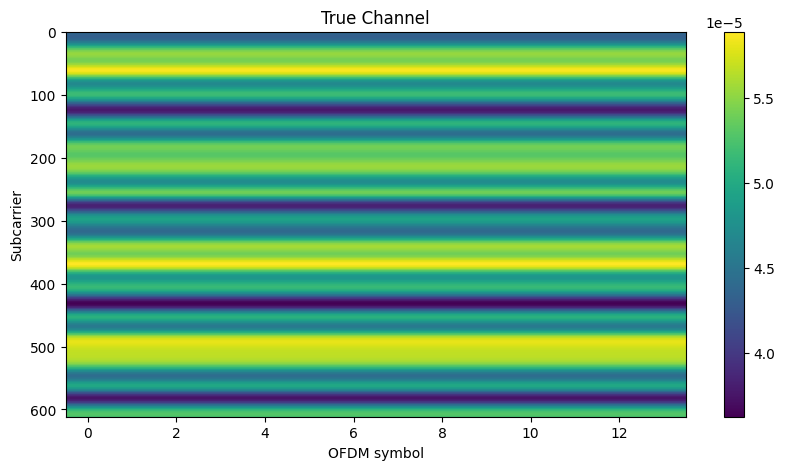

In [ ]:

plt.figure(figsize=(10, 5))
plt.imshow(H_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True Channel')
plt.colorbar()
plt.show()

## Just LS

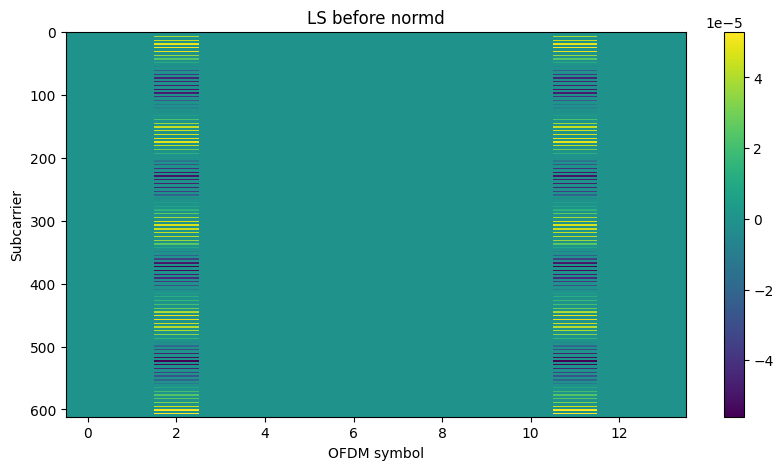

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(H_equal[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS before normd')
plt.colorbar()
plt.show()

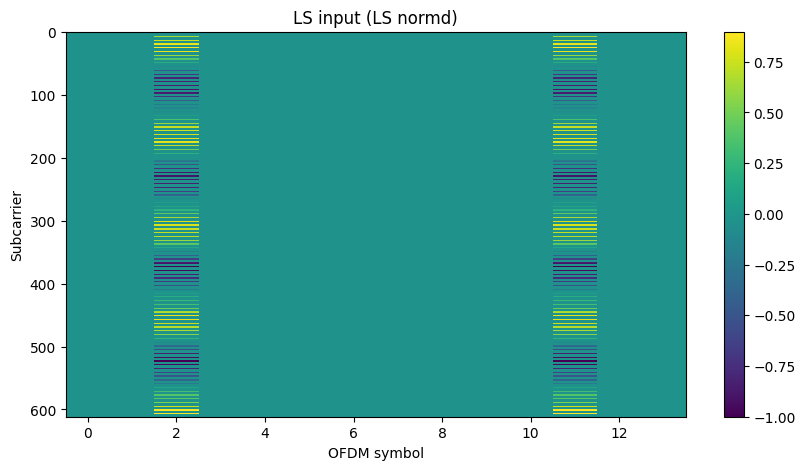

In [ ]:

plt.figure(figsize=(10, 5))
plt.imshow(LS_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS input (LS normd)')
plt.colorbar()
plt.show()

## LS + CNN

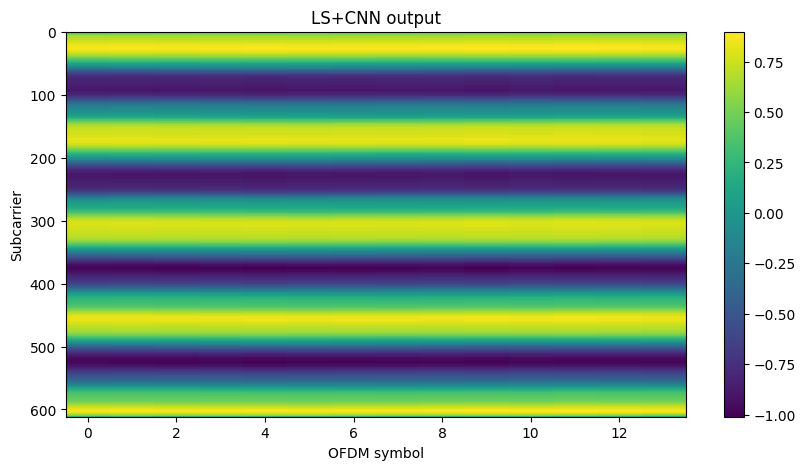

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_NN_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output')
plt.colorbar()
plt.show()

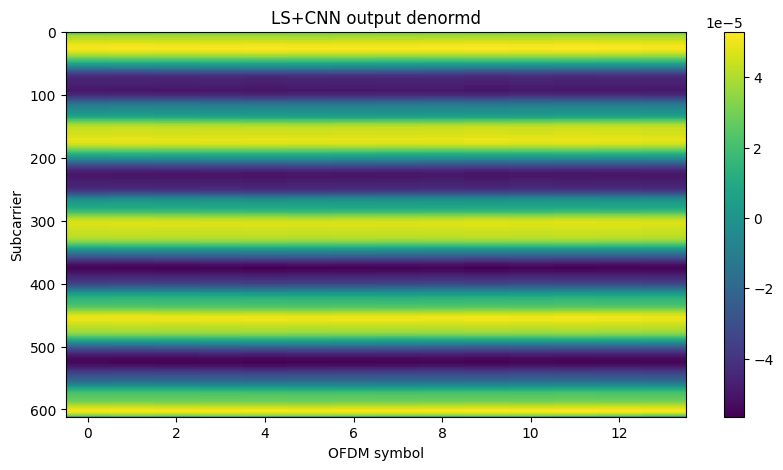

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output denormd')
plt.colorbar()
plt.show()

## LS+LI

Just need to use H_linear straight

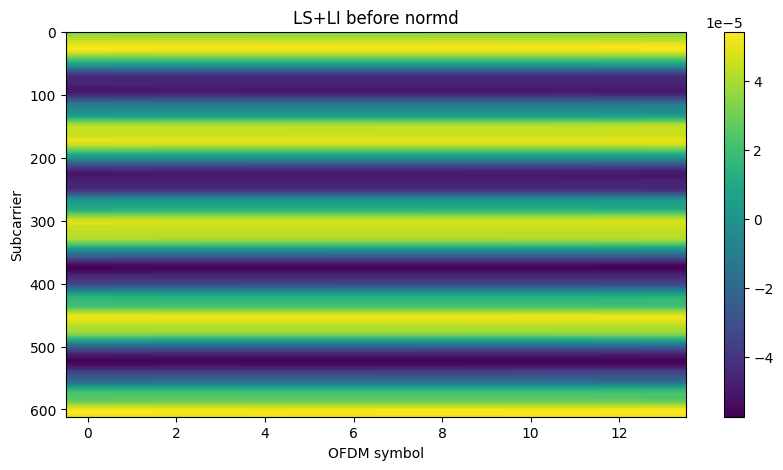

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(H_linear[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI before normd')
plt.colorbar()
plt.show()

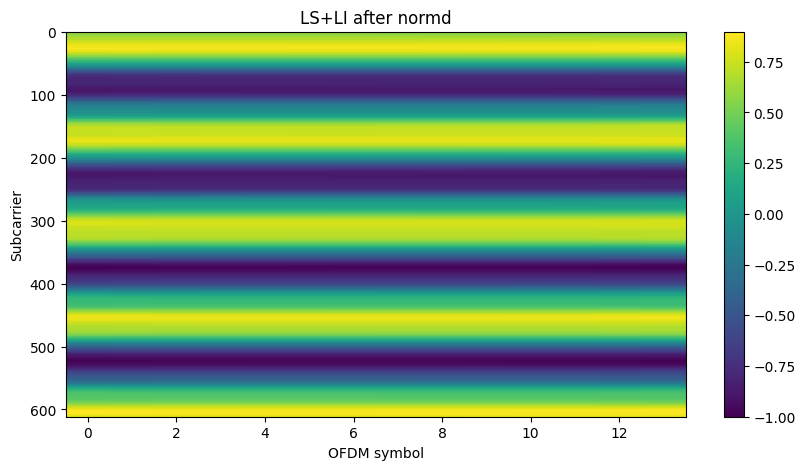

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LI_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI after normd')
plt.colorbar()
plt.show()

## LS+LI+CNN

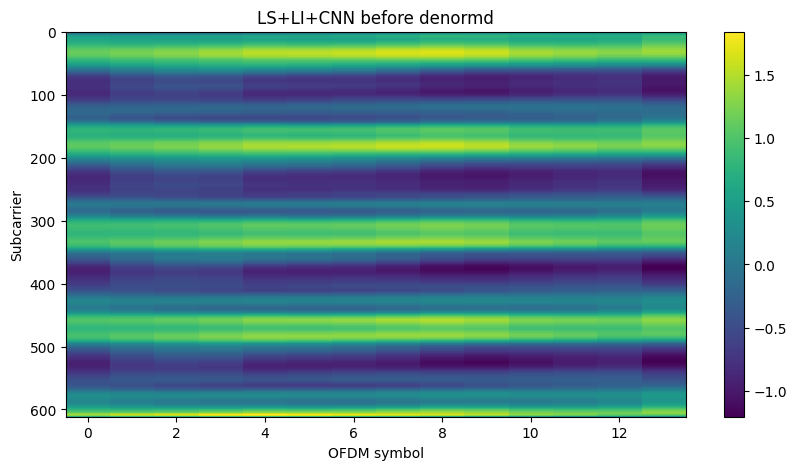

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN before denormd')
plt.colorbar()
plt.show()

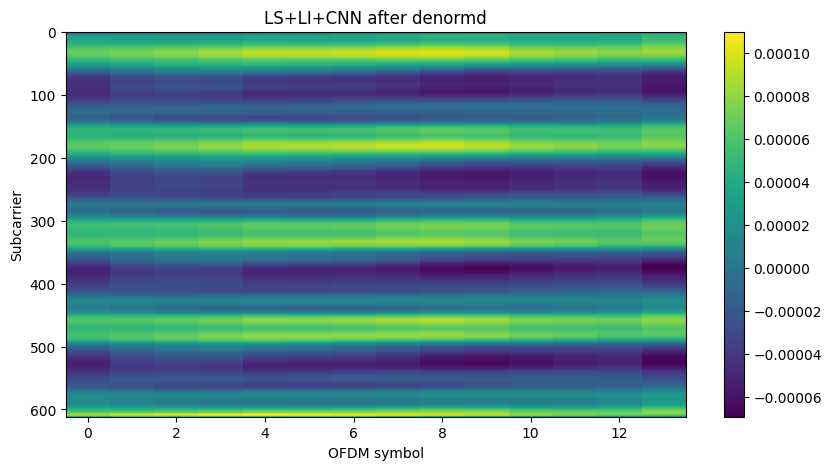

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN after denormd')
plt.colorbar()
plt.show()

## NMSE

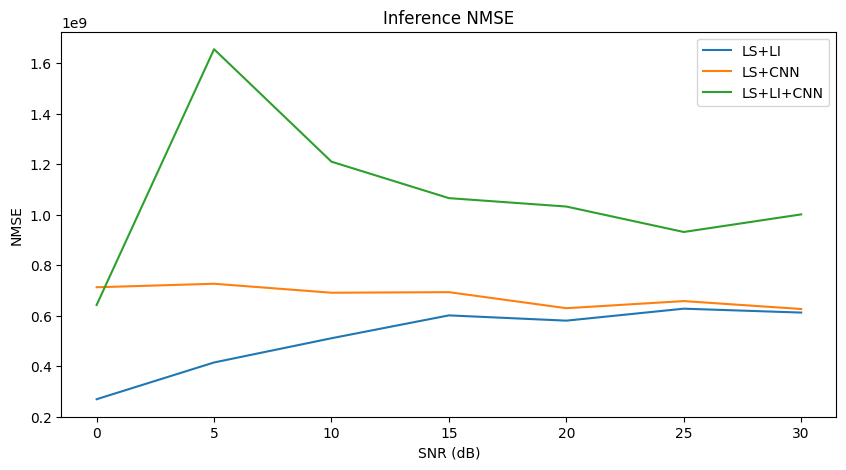

In [ ]:
x = [i * 5 for i in range(len(average_nmse_LS_LI))]

plt.figure(figsize=(10, 5))
plt.plot(x, average_nmse_LS_LI, label = 'LS+LI')
plt.plot(x, average_nmse_LS_NN, label = 'LS+CNN')
plt.plot(x, average_nmse_LI_NN, label = 'LS+LI+CNN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Inference NMSE')
plt.legend()
plt.show()